In [ ]:
'''
model = models.vgg16(pretrained=True)
torch.save(model.state_dict(), 'model_weights.pth')
'''

"\nmodel = models.vgg16(pretrained=True)\ntorch.save(model.state_dict(), 'model_weights.pth')\n"

In [ ]:
!nvidia-smi

Mon Sep 20 11:12:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install pretrainedmodels

     |████████████████████████████████| 58 kB 2.4 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=33db4f132235473588d139bd1781592d9674d480688f514fe51cb707c9517eba
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels


In [ ]:
import pretrainedmodels

In [ ]:
import torch
import torchvision
from torchvision import transforms,models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from skimage import io

import os

import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import shutil
import logging
import torchvision.utils as utils



from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cuda = torch.cuda.is_available()

Mount the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Generate Dataloaders

In [ ]:
def get_loader(data_path,pin_memory=True,num_workers = 8,batch_size = 256):
    """
    Return the dataloader for train,dev and test, along with number of Classes in dataset
    Args:
        pin_memory: (bool) speed up host to device transfer(load samples on CPU push to GPU on training)
        number_workers: (int) multi-process data loading
        batch_size: (int) load data in batches
    
    Returns:
        dataloaders: (DataLoader) train, test, and dev dataloaders
        num_classses: (int) number of different classes of faces in dataset
    """
    transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    #transforms.Resize(32),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),##Add more data Augumentation(Select data augumentation -> None or other options like horizontal flip crop)
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
    # Train Dataset
    train_dataset = torchvision.datasets.ImageFolder(root=data_path+'train/', 
                                                 transform = transform)
    
    # Dev Dataset                                             
    dev_dataset = torchvision.datasets.ImageFolder(root=data_path+'val/', 
                                               transform = transform)
    # Test Dataset
    test_dataset = torchvision.datasets.ImageFolder(root=data_path+'test/', 
                                               transform = transform)
    
    #Trainloader
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               shuffle=True, num_workers=num_workers,pin_memory=True)

    
    # Dev Loader
    dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, 
                                             shuffle=True, num_workers=num_workers, pin_memory=True)

    # Test Loader
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=10, 
                                             shuffle=False, num_workers=num_workers, pin_memory=True)
    
    return train_dataloader, dev_dataloader,test_dataloader, len(train_dataset.classes)

Utilities

In [ ]:
class RunningAverage():
    """A simple class that maintains the running average of a quantity
    
    Example:
    ```
    loss_avg = RunningAverage()
    loss_avg.update(2)
    loss_avg.update(4)
    loss_avg() = 3
    ```
    """
    def __init__(self):
        self.steps = 0
        self.total = 0
    
    def update(self, val):
        self.total += val
        self.steps += 1
    
    def __call__(self):
        return self.total/float(self.steps)


def save_checkpoint(state, is_best, checkpoint):
    """Saves model and training parameters at checkpoint + 'last.pth.tar'. If is_best==True, also saves
    checkpoint + 'best.pth.tar'
    Args:
        state: (dict) contains model's state_dict, may contain other keys such as epoch, optimizer state_dict
        is_best: (bool) True if it is the best model seen till now
        checkpoint: (string) folder where parameters are to be saved
    """
    filepath = os.path.join(checkpoint, 'last.pth.tar')
    if not os.path.exists(checkpoint):
        print("Checkpoint Directory does not exist! Making directory {}".format(checkpoint))
        os.mkdir(checkpoint)
    else:
        print("Checkpoint Directory exists! ")
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'best.pth.tar'))

def load_checkpoint(checkpoint, model, optimizer=None,scheduler=None):
    """Loads model parameters (state_dict) from file_path. If optimizer is provided, loads state_dict of
    optimizer assuming it is present in checkpoint.
    Args:
        checkpoint: (string) filename which needs to be loaded
        model: (torch.nn.Module) model for which the parameters are loaded
        optimizer: (torch.optim) optional: resume optimizer from checkpoint
    """
    if not os.path.exists(checkpoint):
        raise("File doesn't exist {}".format(checkpoint))
    #checkpoint = torch.load(checkpoint)
    checkpoint = torch.load(checkpoint,map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        #optimizer2.load_state_dict(checkpoint['optimizer_closs_state_dict'])
    
    if scheduler:
      scheduler.load_state_dict(checkpoint["scheduler_save"])

    return checkpoint

def set_logger(log_path):
    """Set the logger to log info in terminal and file `log_path`.
    In general, it is useful to have a logger so that every output to the terminal is saved
    in a permanent file. Here we save it to `model_dir/train.log`.
    Example:
    ```
    logging.info("Starting training...")
    ```
    Args:
        log_path: (string) where to log
    """
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)

    if not logger.handlers:
        # Logging to a file
        file_handler = logging.FileHandler(log_path)
        file_handler.setFormatter(logging.Formatter('%(asctime)s:%(levelname)s: %(message)s'))
        logger.addHandler(file_handler)

        # Logging to console
        stream_handler = logging.StreamHandler()
        stream_handler.setFormatter(logging.Formatter('%(message)s'))
        logger.addHandler(stream_handler)

Define Model

In [ ]:
class MyVgg(nn.Module):
  '''
  PreTrained VGG model(fixed Feature Extractor) with
  Attention Mechanism
  https://arxiv.org/pdf/1804.02391v2.pdf
  '''
  def __init__(self):
    super(MyVgg,self).__init__()
    vgg = models.vgg19_bn(pretrained=True)
    list_of_modules = list(next(vgg.children()))
    self.layer1 = nn.Sequential(*list_of_modules[:27])
    self.projector = nn.Conv2d(256, 512, kernel_size=1, padding=0, bias=False)
    self.attn1 =  LinearAttentionBlock(512)
    self.layer2 = nn.Sequential(*list_of_modules[27:40])
    self.attn2 = LinearAttentionBlock(512)
    self.layer3 = nn.Sequential(*list_of_modules[40:])
    self.attn3 = LinearAttentionBlock(512)
    self.dense = nn.Conv2d(512,512, kernel_size=int(224/32), padding=0, bias=True)
    self.freeze()
    self.classify = nn.Linear(512*3,2,bias=True)
  
  def forward(self,x):
    l1 = self.layer1(x)
    l2 = self.layer2(l1)
    l3 = self.layer3(l2)
    g = self.dense(l3)
    c1, g1 = self.attn1(self.projector(l1), g)
    c2, g2 = self.attn2(l2, g)
    c3, g3 = self.attn3(l3, g)
    g = torch.cat((g1,g2,g3), dim=1)
    x = self.classify(g)
    return [x,c1,c2,c3]


  def freeze(self):
    for lay in [self.layer1,self.layer2,self.layer3]:      
      for p in lay.parameters():
        p.requires_grad = False


class LinearAttentionBlock(nn.Module):
    def __init__(self, in_features, normalize_attn=True):
        super(LinearAttentionBlock, self).__init__()
        self.normalize_attn = normalize_attn
        self.op = nn.Conv2d(in_channels=in_features, out_channels=1, kernel_size=1, padding=0, bias=False)
    def forward(self, l, g):
        N, C, W, H = l.size()
        c = self.op(l+g) # batch_sizex1xWxH
        if self.normalize_attn:
            a = F.softmax(c.view(N,1,-1), dim=2).view(N,1,W,H)
        else:
            a = torch.sigmoid(c)
        g = torch.mul(a.expand_as(l), l)
        if self.normalize_attn:
            g = g.view(N,C,-1).sum(dim=2) # batch_sizexC
        else:
            g = F.adaptive_avg_pool2d(g, (1,1)).view(N,C)
        return c.view(N,1,W,H), g


Loss Function

In [ ]:
def cross_entropy(output, labels):
    """
    Loss for Classification
    Args:
        output: (Tensor) Tensor of Prediction made by the model for face class
        labels: (Tensor) True labels for each batch of faces
    """
    return F.cross_entropy(output, labels)

Training - One Epoch

In [ ]:
def one_epoch(epoch,net,loader,optimizer,images_disp):
  net.train()
  running_loss = 0.0
  n = 0
  correct = 0
  total = 0
  loss_avg = RunningAverage()
  with tqdm(total=len(loader)) as t:
    for i,(inputs,labels) in enumerate(loader):
      
      inputs = inputs.to(device)
      labels = labels.to(device)
      if i == 0:
        images_disp.append(inputs[0:36,:,:,:])
      optimizer.zero_grad()
      outputs,_,_,_ = net(inputs)
      #outputs = net(inputs)
      loss = cross_entropy(outputs,labels)
      running_loss += loss.item()
      loss.backward()
      optimizer.step()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      torch.cuda.empty_cache()
      loss_avg.update(loss.item())

      del inputs
      del labels
      del loss
      t.set_postfix(loss='{:05.3f}'.format(loss_avg()))
      t.update()
  avg_loss = running_loss / total
  acc = correct / total *100
  return avg_loss,acc

Inference - One Epoch

In [ ]:
def infer_classfication(net, loader,images_disp):
    net.eval()
    running_loss = 0.0
    n = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (inputs,labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            if i == 0:
              images_disp.append(inputs[0:36,:,:,:])
            outputs,_,_,_ = net(inputs)
            #outputs = net(inputs)
            loss = cross_entropy(outputs,labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del inputs
            del labels

    acc = correct / total * 100
    avg_loss = running_loss / total
    return avg_loss, acc

Training main function

In [ ]:
def train_step(net,loader,dev_loader,optimizer,scheduler,epochs):
  net.train()
  train_losses = []
  valid_losses = []
  valid_acc = []
  auc_acc = []

  best_acc = 0.0
  is_best = False
  for epoch in range(epochs):
    images_disp = []
    for prarm_group in optimizer.param_groups:
      print("Current lr: \t{}".format(prarm_group["lr"]))
      writer.add_scalar('train/learning_rate', optimizer.param_groups[0]['lr'], epoch)
  
    avg_loss_t, acc_t = one_epoch(epoch, net, loader, optimizer,images_disp)

    print(f'\n\n*************\n')
    print('Epoch [%d], loss: %.8f, acc: %.4f' %
                (epoch + 1, avg_loss_t, acc_t))
    avg_loss_v, acc_v = infer_classfication(net, dev_loader,images_disp)
    writer.add_scalar('train/accuracy', acc_t, epoch)
    writer.add_scalar('test/accuracy', acc_v, epoch)
    writer.add_scalar('train/loss', avg_loss_t, epoch)
    writer.add_scalar('test/loss', avg_loss_v, epoch)
    I_train = utils.make_grid(images_disp[0], nrow=6, normalize=True, scale_each=True)
    writer.add_image('train/image', I_train, epoch)
    if epoch == 0:
      I_test = utils.make_grid(images_disp[1], nrow=6, normalize=True, scale_each=True)
      writer.add_image('test/image', I_test, epoch)
    
    min_up_factor = 8
    vis_fun = visualize_attn_softmax
    #vis_fun = visualize_attn_sigmoid
    __, c1, c2, c3 = net(images_disp[0])
    
    if c1 is not None:
        attn1 = vis_fun(I_train, c1, up_factor=min_up_factor, nrow=6)
        writer.add_image('train/attention_map_1', attn1, epoch)
    if c2 is not None:
        attn2 = vis_fun(I_train, c2, up_factor=min_up_factor*2, nrow=6)
        writer.add_image('train/attention_map_2', attn2, epoch)
    if c3 is not None:
        attn3 = vis_fun(I_train, c3, up_factor=min_up_factor*4, nrow=6)
        writer.add_image('train/attention_map_3', attn3, epoch)
    # test data
    
    __, c1, c2, c3 = net(images_disp[1])
    if c1 is not None:
        attn1 = vis_fun(I_test, c1, up_factor=min_up_factor, nrow=6)
        writer.add_image('test/attention_map_1', attn1, epoch)
    if c2 is not None:
        attn2 = vis_fun(I_test, c2, up_factor=min_up_factor*2, nrow=6)
        writer.add_image('test/attention_map_2', attn2, epoch)
    if c3 is not None:
        attn3 = vis_fun(I_test, c3, up_factor=min_up_factor*4, nrow=6)
        writer.add_image('test/attention_map_3', attn3, epoch)
    
    valid_losses.append(avg_loss_v)
    valid_acc.append(acc_v)   
    print('[Classification valid] loss: %.8f, acc: %.4f\n\n' % (avg_loss_v, acc_v))
    if acc_v > best_acc:
      is_best = True
    #scheduler.step() # StepLR
    scheduler.step(avg_loss_v) # ReduceonPlateau
    train_losses.append(avg_loss_t)
    print('\n','='*20)
    #print("*** Saving Checkpoint ***\n")
    
    '''
    save_checkpoint({'epoch': epoch + 1,
                               'model_state_dict': net.state_dict(),
                               'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_save' : scheduler.state_dict(),
                               'train_loss': train_losses,
                                'dev_loss':valid_losses,
                                'dev_acc': valid_acc,},
                              is_best=is_best,
                              checkpoint = hyper_param["ckpnt_training"]
                              #checkpoint="/content/gdrive/MyDrive/capstone/workings/Project_LocalMachine/checkpoint"
                              )
    '''
    
  return train_losses, valid_losses,valid_acc

Visualize Attention

In [ ]:

import cv2


def visualize_attn_softmax(I, c, up_factor, nrow):
    # image
    img = I.permute((1,2,0)).cpu().numpy()
    # compute the heatmap
    N,C,W,H = c.size()
    a = F.softmax(c.view(N,C,-1), dim=2).view(N,C,W,H)
    #a = F.interpolate(a, scale_factor=up_factor, mode='bilinear', align_corners=False)
    a = F.interpolate(a,size=224)
    #if up_factor > 1:
    #    a = F.interpolate(a, scale_factor=up_factor, mode='bilinear', align_corners=False)
    attn = utils.make_grid(a, nrow=nrow, normalize=True, scale_each=True)
    attn = attn.permute((1,2,0)).mul(255).byte().cpu().numpy()
    attn = cv2.applyColorMap(attn, cv2.COLORMAP_JET)
    attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
    attn = np.float32(attn) / 255
    # add the heatmap to the image
    vis = 0.6 * img + 0.4 * attn
    return torch.from_numpy(vis).permute(2,0,1)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
model_name = 'xception'
model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
print(model)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


  0%|          | 0.00/87.4M [00:00<?, ?B/s]

KeyboardInterrupt: ignored

In [ ]:
def main():
  # Set the logger
  #set_logger(os.path.join('/content/gdrive/MyDrive/capstone/workings/Project_LocalMachine/checkpoint', 'train.log'))
  # from torch.utils.tensorboard import SummaryWriter
  # writer = SummaryWriter()

  logging.info("Loading the datasets...")
  # fetch dataloaders
  train_dataloader, dev_dataloader,test_dataloader, num_classes = get_loader(hyper_param["data_path"]
                                                                             ,num_workers=hyper_param["num_workers"]
                                                                             ,batch_size = hyper_param["batch_size"])
  logging.info("- done.")
  
  logging.info("Loading the Pretrained Resnet18 Model for Transfer Learning")
  #Model based on Resnet18(Transfer Learning)
  
  #tl_resnet50 = models.resnet50(pretrained=True)
  #tl_resnet50 = models.wide_resnet101_2(pretrained=True)
  '''
  #XCEPTION
  model_name = 'xception'
  tl_resnet50 = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
  print(tl_resnet50)
  logging.info("- done.")
  #Freeze the wait to covert from fine tuining TL to fixed feature extractor
  
  for param in tl_resnet50.parameters():
    if param.grad_fn != None:
      param.requires_grad = False

  
  
   

  #num_ftrs = tl_resnet50.classifier[6].in_features
  #tl_resnet50.classifier[6] = nn.Linear(num_ftrs, 2)
  #num_ftrs = tl_resnet50.fc.in_features
  num_ftrs=tl_resnet50.last_linear.in_features
  tl_resnet50.fc = nn.Linear(num_ftrs, 2)
  tl_resnet50.to(device)
  print(tl_resnet50)
  '''

  
  tl_resnet50 = MyVgg()
  tl_resnet50.freeze()
  tl_resnet50.to(device)
  print(tl_resnet50)
  
  #Adam_optimizer = torch.optim.Adam(tl_resnet50.parameters(),lr = hyper_param["lr"])
  Adam_optimizer = optim.SGD(tl_resnet50.parameters(), lr=hyper_param["lr"], momentum=0.9, weight_decay=5e-4)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(Adam_optimizer,mode='min',patience=1)
  #scheduler = None
  
  '''
  checkpoint_path =hyper_param['ckpnt_training']+'/last.pth.tar'
  #checkpoint_path = "/content/gdrive/MyDrive/capstone/workings/Project_LocalMachine/checkpoint/last.pth.tar"
  loaded_checkpoint = load_checkpoint(checkpoint_path,tl_resnet50,Adam_optimizer,scheduler)
  train_loss,dev_loss,d_acc = loaded_checkpoint["train_loss"],loaded_checkpoint["dev_loss"], loaded_checkpoint["dev_acc"]
  print('='*20)
  print(train_loss,dev_loss,d_acc)
  print('='*20)
  '''
  
  logging.info(f"Starting training for {hyper_param['numEpochs']} epoch(s)")
  train_losses, valid_losses, valid_acc = train_step(tl_resnet50, train_dataloader, dev_dataloader,Adam_optimizer,scheduler,hyper_param["numEpochs"])

In [ ]:
if __name__ == "__main__":
  hyper_param = {
    "lr": 1e-3,
    "batch_size": 64,
    "numEpochs": 100, 
    "num_workers": 2,
    "ckpnt_training": "/content/gdrive/MyDrive/capstone/checkpoint",
    "checkpoint":"/content/gdrive/MyDrive/capstone/checkpoint/last.pth.tar",
    "data_path":"/content/gdrive/MyDrive/capstone/workings/Project_LocalMachine/data2/images_handheld/"
  }
  main()

MyVgg(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

100%|██████████| 20/20 [00:26<00:00,  1.31s/it, loss=0.693]



*************

Epoch [1], loss: 0.01128057, acc: 51.3029


[Classification valid] loss: 0.01349216, acc: 52.5974



Current lr: 	0.001


100%|██████████| 20/20 [00:27<00:00,  1.35s/it, loss=0.689]



*************

Epoch [2], loss: 0.01121885, acc: 55.2932


[Classification valid] loss: 0.01339949, acc: 59.0909



Current lr: 	0.001


100%|██████████| 20/20 [00:26<00:00,  1.35s/it, loss=0.686]



*************

Epoch [3], loss: 0.01117001, acc: 59.9349


[Classification valid] loss: 0.01333759, acc: 64.2857



Current lr: 	0.001


100%|██████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.683]



*************

Epoch [4], loss: 0.01112400, acc: 63.1107


[Classification valid] loss: 0.01329134, acc: 66.2338



Current lr: 	0.001


100%|██████████| 20/20 [00:26<00:00,  1.33s/it, loss=0.681]



*************

Epoch [5], loss: 0.01108445, acc: 66.0423


[Classification valid] loss: 0.01326776, acc: 71.4286



Current lr: 	0.001


100%|██████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.677]



*************

Epoch [6], loss: 0.01102493, acc: 70.1140


[Classification valid] loss: 0.01314143, acc: 70.7792



Current lr: 	0.001


100%|██████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.675]



*************

Epoch [7], loss: 0.01098657, acc: 70.1140


[Classification valid] loss: 0.01316619, acc: 76.6234



Current lr: 	0.001


100%|██████████| 20/20 [00:27<00:00,  1.35s/it, loss=0.671]



*************

Epoch [8], loss: 0.01092227, acc: 73.3713


[Classification valid] loss: 0.01302277, acc: 75.3247



Current lr: 	0.001


100%|██████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.668]



*************

Epoch [9], loss: 0.01088220, acc: 73.9414


[Classification valid] loss: 0.01303188, acc: 75.3247



Current lr: 	0.001


100%|██████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.665]



*************

Epoch [10], loss: 0.01083706, acc: 73.4528


[Classification valid] loss: 0.01297879, acc: 74.0260



Current lr: 	0.001


100%|██████████| 20/20 [00:26<00:00,  1.35s/it, loss=0.661]



*************

Epoch [11], loss: 0.01077317, acc: 74.2671


[Classification valid] loss: 0.01292092, acc: 70.7792



Current lr: 	0.001


100%|██████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.660]



*************

Epoch [12], loss: 0.01075183, acc: 68.7296


[Classification valid] loss: 0.01285321, acc: 68.8312



Current lr: 	0.001


 20%|██        | 4/20 [00:07<00:31,  1.94s/it, loss=0.658]


KeyboardInterrupt: ignored

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir ./runs/ --samples_per_plugin images=100

Check Pretrained VGG Extractor Parameters

Inference

In [ ]:
'''
tl_resnet50 = MyVgg()
tl_resnet50.freeze()
tl_resnet50.to(device)
print(tl_resnet50)
'''
model_name = 'xception'
tl_resnet50 = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')

for param in tl_resnet50.parameters():
  if param.grad_fn != None:
    param.requires_grad = False


num_ftrs=tl_resnet50.last_linear.in_features
tl_resnet50.fc = nn.Linear(num_ftrs, 2)
tl_resnet50.to(device)
print(tl_resnet50)

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Co

In [ ]:
checkpoint_path = "/content/gdrive/MyDrive/capstone/checkpoint/best.pth.tar"
checkpoint_infer = load_checkpoint(checkpoint_path,tl_resnet50,None,None)

In [ ]:
hyper_param = {
    "lr": 1e-2,
    "batch_size": 64,
    "numEpochs": 8, 
    "num_workers": 4,
    "ckpnt_training": "/content/gdrive/MyDrive/capstone/checkpoint",
    "checkpoint":"/content/gdrive/MyDrive/capstone/checkpoint/last.pth.tar",
    "data_path":"/content/gdrive/MyDrive/capstone/data/"
  }
train_dataloader, dev_dataloader,test_dataloader, num_classes = get_loader(hyper_param["data_path"]
                                                                             ,num_workers=hyper_param["num_workers"]
                                                                             ,batch_size = hyper_param["batch_size"])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
avg_loss_test, acc_test = infer_classfication(tl_resnet50,test_dataloader,[])
print(f"*** Classifier <-> Feature Extractor\n [Test] Loss:{avg_loss_test} \t Accuracy:{acc_test} ")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


*** Classifier <-> Feature Extractor
 [Test] Loss:0.03361754225446813 	 Accuracy:89.03225806451613 


In [ ]:
data_iter = iter(test_dataloader)
images,_ = next(data_iter)
_,_,_,c3 = tl_resnet50(images[0].reshape(1,3,224,224).to(device))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:

import cv2


def visualize_attn_softmax(I, c, up_factor, nrow):
    # image
    img = I.permute((1,2,0)).cpu().numpy()
    # compute the heatmap
    N,C,W,H = c.size()
    a = F.softmax(c.view(N,C,-1), dim=2).view(N,C,W,H)
    a = F.interpolate(a, scale_factor=up_factor, mode='bilinear', align_corners=False)
    print('###############',a.size())
    #if up_factor > 1:
    #    a = F.interpolate(a, scale_factor=up_factor, mode='bilinear', align_corners=False)
    attn = utils.make_grid(a, nrow=nrow, normalize=True, scale_each=True)
    attn = attn.permute((1,2,0)).mul(255).byte().cpu().numpy()
    attn = cv2.applyColorMap(attn, cv2.COLORMAP_JET)
    attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
    attn = np.float32(attn) / 255
    # add the heatmap to the image
    vis = 0.6 * img + 0.4 * attn
    return torch.from_numpy(vis).permute(2,0,1)

In [ ]:
img = utils.make_grid(images[0].view(1,3,224,224), nrow=1, normalize=True, scale_each=True)

############### torch.Size([1, 1, 224, 224])


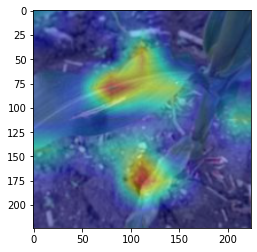

In [ ]:
plt.imshow(visualize_attn_softmax(img,c3,32,nrow=1).permute(1,2,0))